In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
json_file_path = '/content/drive/MyDrive/Colab Notebooks/train.json'
import json
with open(json_file_path, 'r') as file:
    train_data = json.load(file)


In [ ]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

clinical_bert_model = BertModel.from_pretrained('bert-large-uncased', )

In [ ]:
print(clinical_bert_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [ ]:
label_mapping = {
    'Entailment': 1,
    'Contradiction': 0
}

In [ ]:
import json
import os
import re
import random
from torch.utils.data import DataLoader


ctr_json_folder = '/content/drive/MyDrive/Colab Notebooks/CT json' 




def preprocess_data(train_data):
    preprocessed_data = []
    for data_id, data in train_data.items():
        ctr_1 = data['Primary_id'] + '.json'
        ctr_1f = os.path.join(ctr_json_folder, ctr_1)
        secondaryid_exists = False
        if 'Secondary_id' in data:
            ctr_2 = data['Secondary_id'] + '.json'
            ctr_2f = os.path.join(ctr_json_folder, ctr_2)
            secondaryid_exists = True

        with open(ctr_1f, 'r') as file:
            ctr_a = json.load(file)
            if secondaryid_exists:
                with open(ctr_2f, 'r') as file:
                    ctr_b = json.load(file)
                ctr = "Compare CTR 1" + " [SEP] ".join(ctr_a[data['Section_id']])  + "[SEP]"+ "and CTR 2" + " [SEP] ".join(
                    ctr_b[data["Section_id"]]) + "to determine if the given statement" + " [SEP] " + data["Statement"] +"[SEP]"+"is true"
            else:
                ctr = "Analyze CTR 1" + " [SEP] ".join(ctr_a[data['Section_id']]) + "[SEP]"+" To determine if the given Statement" + " [SEP] " + data["Statement"]+"[SEP]"+"is true"
        ctr = ctr.lower()
        url_ptrn = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

        ctr = re.sub(url_ptrn, '', ctr)
        ctr = re.sub(r'[^\w\s]', '', ctr)

        inputs = tokenizer(ctr, return_tensors='pt', max_length=512, padding='max_length', truncation=True)
        labels = torch.tensor([label_mapping[data['Label']]])

        preprocessed_data.append((inputs, labels))

    return preprocessed_data


In [ ]:

preprocessed_data = preprocess_data(train_data)



In [ ]:
print(len(preprocessed_data))

1700


In [ ]:
import json
with open('/content/drive/MyDrive/Colab Notebooks/dev.json', 'r') as file:
    dev_data = json.load(file)

dev_preprocessed_data = preprocess_data(dev_data)

In [ ]:
import numpy as np


data = preprocessed_data + dev_preprocessed_data
data = list(data)
val_size = int(len(data) * 0.15)

np.random.shuffle(data)

val_data = data[:val_size]
train_data = data[val_size:]


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
for param in list(clinical_bert_model.parameters())[:-3]:
    param.requires_grad = False

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F

class CustomClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),  
            nn.ReLU(),            
            nn.Dropout(0.1),      
            nn.Linear(512, 256),  
            nn.ReLU(),            
            nn.Dropout(0.1),     
            nn.Linear(256, num_classes)  
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  
        logits = self.classifier(pooled_output)
        return logits

num_classes = 2  
model = CustomClassifier(clinical_bert_model, num_classes)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
from sklearn.metrics import accuracy_score


device = torch.device('cuda')

model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
NUM_EPOCHS=50
best_val_acc = float('-inf')


for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    train_predicted = []
    train_labels = []
    for batch in train_loader:
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']

        labels = batch[1]
        labels.to(device)
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask).to(device)
        loss_fn = nn.CrossEntropyLoss()
        logits = logits.squeeze(1)
        labels = labels.squeeze(1)
        labels = labels.to(logits.device)

        loss = F.binary_cross_entropy_with_logits(logits[:, 1], labels.float())

        loss.backward()

        total_train_loss += loss.item()

        optimizer.step()
        _, predicted = torch.max(logits, 1)
        train_predicted.extend(predicted.tolist())
        train_labels.extend(labels.tolist())
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    train_loss = total_train_loss / len(train_loader)
    train_acc_score = accuracy_score(train_labels, train_predicted)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc_score)


    # Validation
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_predicted = []
    val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch[0]['input_ids']
            attention_mask = batch[0]['attention_mask']

            labels = batch[1]
            labels.to(device)
            input_ids = input_ids.squeeze(1).to(device)
            attention_mask = attention_mask.squeeze(1).to(device)
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask).to(device)
            loss_fn = nn.CrossEntropyLoss()
            logits = logits.squeeze(1)
            labels = labels.squeeze(1)
            labels = labels.to(logits.device)

            loss = F.binary_cross_entropy_with_logits(logits[:, 1], labels.float())

            total_val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            val_predicted.extend(predicted.tolist())
            val_labels.extend(labels.tolist())
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = total_val_loss / len(val_loader)
    val_acc_score = accuracy_score(val_labels, val_predicted)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc_score)

    if val_acc_score > best_val_acc:

        best_val_acc = val_acc_score
        torch.save(model.state_dict(), 'NLP_milestone3_withoutAug_snow_model_state.pth')

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc_score:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc_score:.4f}')

Epoch 1/50, Train Loss: 0.7043, Train Accuracy: 0.4954, Val Loss: 0.7060, Val Accuracy: 0.4632
Epoch 2/50, Train Loss: 0.7141, Train Accuracy: 0.4663, Val Loss: 0.7065, Val Accuracy: 0.4632
Epoch 3/50, Train Loss: 0.7092, Train Accuracy: 0.5022, Val Loss: 0.7154, Val Accuracy: 0.4632
Epoch 4/50, Train Loss: 0.7022, Train Accuracy: 0.4978, Val Loss: 0.7127, Val Accuracy: 0.4632
Epoch 5/50, Train Loss: 0.7044, Train Accuracy: 0.4954, Val Loss: 0.7135, Val Accuracy: 0.4632
Epoch 6/50, Train Loss: 0.6985, Train Accuracy: 0.5220, Val Loss: 0.7125, Val Accuracy: 0.4632
Epoch 7/50, Train Loss: 0.7087, Train Accuracy: 0.4935, Val Loss: 0.7095, Val Accuracy: 0.4632
Epoch 8/50, Train Loss: 0.7102, Train Accuracy: 0.4960, Val Loss: 0.7118, Val Accuracy: 0.4632
Epoch 9/50, Train Loss: 0.7002, Train Accuracy: 0.5127, Val Loss: 0.7141, Val Accuracy: 0.4632
Epoch 10/50, Train Loss: 0.7033, Train Accuracy: 0.5053, Val Loss: 0.7121, Val Accuracy: 0.4632
Epoch 11/50, Train Loss: 0.7166, Train Accuracy: 

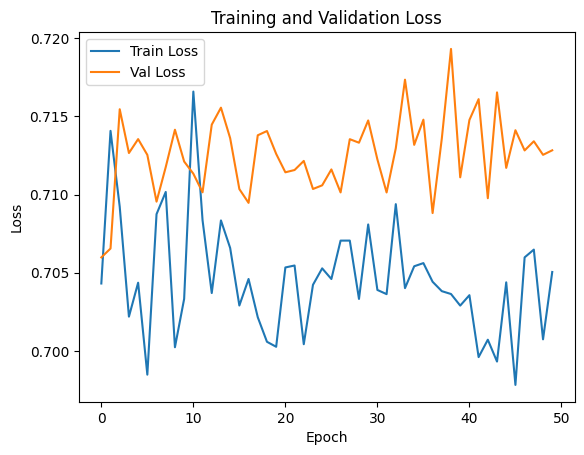

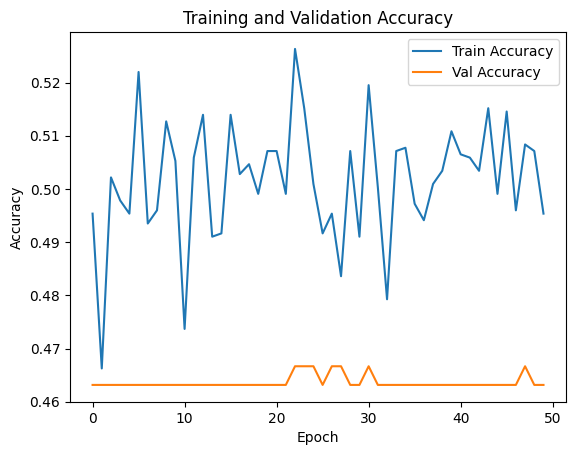

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot( val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot( train_accuracies, label='Train Accuracy')
plt.plot( val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']
        labels = batch[1].to(device)
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]


Accuracy: 0.4632
Precision: 0.2145, Recall: 0.4632, F1 Score: 0.2932


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


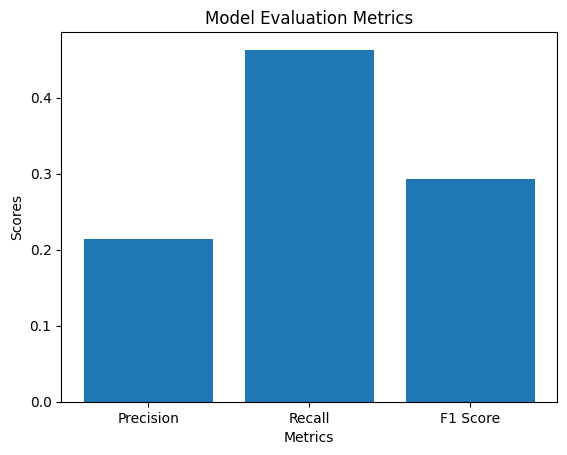

In [ ]:

plt.bar(labels, scores)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')
plt.show()




In [ ]:
# model.load_state_dict(torch.load('milestone2_NLP_model_state.pth'))

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [ ]:
json_file_path = '/content/drive/MyDrive/Colab Notebooks/gold_practice_test.json'
import json
# Load the JSON file
with open(json_file_path, 'r') as file:
    gold_practice_test = json.load(file)


In [ ]:
def preprocess_test_data(train_data):
    preprocessed_data = []

    for data_id, data in train_data.items():
        ctr_1 = data['Primary_id'] + '.json'
        ctr_1f = os.path.join('/content/drive/MyDrive/Colab Notebooks/CT json', ctr_1)
        secondaryid_exists = False
        if 'Secondary_id' in data:
            ctr_2 = data['Secondary_id'] + '.json'
            ctr_2f = os.path.join('/content/drive/MyDrive/Colab Notebooks/CT json', ctr_2)
            secondaryid_exists = True

        with open(ctr_1f, 'r') as file:
            ctr_a = json.load(file)
            if secondaryid_exists:
                with open(ctr_2f, 'r') as file:
                    ctr_b = json.load(file)
                ctr = "CTR 1" + " [SEP] ".join(ctr_a[data['Section_id']]) +"[SEP]"+ "CTR 2" + " [SEP] ".join(
                    ctr_b[data["Section_id"]]) + "[SEP]"+"Data" + " [SEP] " + data["Statement"]
            else:
                ctr = "CTR 1" + " [SEP] ".join(ctr_a[data['Section_id']]) + "[SEP]"+"Data" + " [SEP] " + data["Statement"]
        ctr = ctr.lower()
        url_ptrn = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

        ctr = re.sub(url_ptrn, '', ctr)
        ctr = re.sub(r'[^\w\s]', '', ctr)

        inputs = tokenizer(ctr, return_tensors='pt', max_length=512, padding='max_length', truncation=True)
        labels = torch.tensor([label_mapping[data['Label']]])

        preprocessed_data.append((inputs, labels))


    return preprocessed_data


In [ ]:
gold_test = preprocess_test_data(gold_practice_test)

In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
gold_test_loader = DataLoader(gold_test, batch_size=batch_size)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in gold_test_loader:
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']
        labels = batch[1].to(device)
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())


In [ ]:
import numpy as np

true_labels = np.array(true_labels)
predictions = np.array(predictions)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]


Accuracy: 0.3422
Precision: 0.5871, Recall: 0.3422, F1 Score: 0.1778


In [ ]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
faithfulness = sum(abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

In [ ]:
print(faithfulness)

[0.65779645]


In [ ]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
consistency = sum(1-abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

In [ ]:
print(consistency)

[0.34220355]


In [ ]:
json_file_path = '/content/drive/MyDrive/Colab Notebooks/test.json'
import json
with open(json_file_path, 'r') as file:
    test_data = json.load(file)



In [ ]:
import json

test_preprocessed_data = []
data_ids = [] 
for data_id, data in test_data.items():
    ctr_1 = data['Primary_id'] + '.json'
    ctr_1f = os.path.join('/content/drive/MyDrive/Colab Notebooks/CT json', ctr_1)
    secondaryid_exists = False
    if 'Secondary_id' in data:
        ctr_2 = data['Secondary_id'] + '.json'
        ctr_2f = os.path.join('/content/drive/MyDrive/Colab Notebooks/CT json', ctr_2)
        secondaryid_exists = True

    with open(ctr_1f, 'r') as file:
        ctr_a = json.load(file)
        if secondaryid_exists:
            with open(ctr_2f, 'r') as file:
                ctr_b = json.load(file)
            ctr = " ".join(ctr_a[data['Section_id']]) + " [SEP] " + \
                  " ".join(ctr_b[data["Section_id"]]) + " [SEP] " + data["Statement"]
        else:
            ctr = " ".join(ctr_a[data['Section_id']]) + " [SEP] " + data["Statement"]

    ctr = ctr.lower()
    url_ptrn = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    ctr = re.sub(url_ptrn, '', ctr)
    ctr = re.sub(r'[^\w\s]', '', ctr)

    inputs = tokenizer(ctr, return_tensors='pt', max_length=512, padding='max_length', truncation=True)

    test_preprocessed_data.append(inputs)
    data_ids.append(data_id) 


In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
test_loader = DataLoader(test_preprocessed_data, batch_size=batch_size)

In [ ]:

model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:  
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())


In [ ]:

predictions_dict = {}
for data_id, prediction in zip(data_ids, predictions):
    prediction_label = "Contradiction" if prediction == 0 else "Entailment"
    predictions_dict[data_id] = {"Prediction": prediction_label}

output_file_path = "/content/drive/MyDrive/Colab Notebooks/BertLargepredictions_2.json"
with open(output_file_path, "w") as f:
    json.dump(predictions_dict, f, indent=4)

print("Predictions saved to:", output_file_path)


Predictions saved to: /content/drive/MyDrive/Colab Notebooks/BertLargepredictions_2.json
